# Beach Crowd Prediction — PyTorch-Forecasting TFT

Temporal chunking experiments with **PyTorch-Forecasting TFT** (daytime-only) across:
1. **Simple Sliding** — 2 chunks train, 1 val, 1 test
2. **Expanding Rolling** — growing train, 1 val, 1 test
3. **Split-Gap** — 40% early + 40% late (20% gap)

Uses `TimeSeriesDataSet` with integer `time_idx` — no night bias.


In [1]:
# === PATHS ===
CACHE_DIR = "cache/predictions"
COUNTING_MODEL = "bayesian_vgg19"
SAVE_DIR = "models/tft_chunks"

# === SAMPLING ===
SAMPLE_FRAC = 0.5
MAX_BEACHES = 3

# === TFT PARAMETERS ===
MAX_STEPS = 500
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
INPUT_SIZE = 48
HORIZON = 168  # 1 week = 7 days

# === TIME ===
NIGHT_START = 20
NIGHT_END = 6

# === FLAGS ===
RUN_SKLEARN = False
RUN_NEURALFORECAST = True
RUN_OPTUNA = False

In [2]:
import subprocess, sys
for pkg in ["neuralforecast", "utilsforecast", "pytorch-forecasting", "pytorch_optimizer"]:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])


In [3]:
import json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import MAE

HAS_NF = True

if torch.cuda.is_available():
    ACCELERATOR = 'gpu'
    DEVICES = 1
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    ACCELERATOR = 'mps'
    DEVICES = 1
else:
    ACCELERATOR = 'cpu'
    DEVICES = 1

print(f"Device: {ACCELERATOR} | PyTorch: {torch.__version__}")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE as PF_MAE, QuantileLoss

print("pytorch-forecasting imported successfully")


Device: mps | PyTorch: 2.9.1
pytorch-forecasting imported successfully


In [4]:
def calc_metrics(y_true, y_pred, max_count):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rel_mae = (mae / max_count) * 100 if max_count > 0 else 0
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'RelMAE': rel_mae}

def eval_per_beach(df, y_pred, beach_col='unique_id'):
    results = []
    for b in df[beach_col].unique():
        mask = df[beach_col] == b
        if mask.sum() < 3:
            continue
        y_true = df.loc[mask, 'y'].values if 'y' in df.columns else df.loc[mask, 'count'].values
        y_p = y_pred[mask.values] if hasattr(mask, 'values') else y_pred[mask]
        max_count = y_true.max()
        m = calc_metrics(y_true, y_p, max_count)
        m['camera'] = b
        m['max_count'] = max_count
        m['n'] = mask.sum()
        results.append(m)
    return pd.DataFrame(results)

## Load and Prepare Data


In [5]:
def load_cache(cache_dir, model):
    cache_path = Path(cache_dir) / model
    records = []
    for jf in cache_path.rglob("*.json"):
        try:
            with open(jf) as f:
                r = json.load(f)
            if 'error' not in r:
                records.append(r)
        except: pass
    
    rows = []
    for r in records:
        row = {
            'beach': r.get('beach') or r.get('beach_folder'),
            'beach_folder': r.get('beach_folder'),
            'datetime': r.get('datetime'),
            'count': r.get('count')
        }
        for k, v in r.get('weather', {}).items():
            row[k] = v
        rows.append(row)
    
    df = pd.DataFrame(rows)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

df_raw = load_cache(CACHE_DIR, COUNTING_MODEL)
print(f"Loaded: {len(df_raw)} rows, {df_raw['beach'].nunique()} beaches")

Loaded: 169241 rows, 41 beaches


In [6]:
EXCLUDE = ['livecampro/001', 'livecampro/011', 'livecampro/018', 'livecampro/021',
    'livecampro/030', 'livecampro/039', 'livecampro/070', 'MultimediaTres/PortAndratx',
    'SeeTheWorld/mallorca_pancam', 'skyline/es-pujols']
EXCLUDE_PREFIX = ['ibred', 'ClubNauticSoller', 'Guenthoer', 'youtube']

before = len(df_raw)
df_raw = df_raw[~df_raw['beach_folder'].isin(EXCLUDE)]
for p in EXCLUDE_PREFIX:
    df_raw = df_raw[~df_raw['beach_folder'].str.startswith(p, na=False)]
print(f"Filtered: {before} -> {len(df_raw)}")

Filtered: 169241 -> 70501


In [7]:
if SAMPLE_FRAC < 1.0:
    df_raw = df_raw.sample(frac=SAMPLE_FRAC, random_state=42).sort_values('datetime').reset_index(drop=True)

if MAX_BEACHES:
    top = df_raw['beach'].value_counts().head(MAX_BEACHES).index.tolist()
    df_raw = df_raw[df_raw['beach'].isin(top)].reset_index(drop=True)

print(f"Final: {len(df_raw)} rows, {df_raw['beach'].nunique()} beaches")

Final: 11123 rows, 3 beaches


In [8]:
df = df_raw.copy()
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_night'] = ((df['hour'] >= NIGHT_START) | (df['hour'] <= NIGHT_END)).astype(int)

WEATHER_COLS = [c for c in df.columns if c.startswith('ae_') or c.startswith('om_')]
TEMPORAL_COLS = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_summer', 'is_night']
ALL_FEATURES = WEATHER_COLS + TEMPORAL_COLS

df = df.dropna(subset=ALL_FEATURES + ['count']).reset_index(drop=True)
good = df.groupby('beach')['count'].max()
good = good[good > 20].index.tolist()
df = df[df['beach'].isin(good)].reset_index(drop=True)

print(f"After cleaning: {len(df)} rows, {len(good)} beaches")
print(f"Features: {len(ALL_FEATURES)}")

After cleaning: 11013 rows, 3 beaches
Features: 35


## Create Dataset Strategies


In [9]:
ds_daytime = df[df['is_night'] == 0].copy().reset_index(drop=True)
ds_full24h = df.copy()
ds_night0 = df.copy()
ds_night0.loc[ds_night0['is_night'] == 1, 'count'] = 0.0

ds_nightq1 = df.copy()
q1_per_beach = ds_nightq1[ds_nightq1['is_night'] == 0].groupby('beach')['count'].quantile(0.25)
ds_nightq1.loc[ds_nightq1['is_night'] == 1, 'count'] = ds_nightq1.loc[ds_nightq1['is_night'] == 1, 'beach'].map(q1_per_beach).fillna(0)

ds_nightmin = df.copy()
min_per_beach = ds_nightmin[ds_nightmin['is_night'] == 0].groupby('beach')['count'].min()
ds_nightmin.loc[ds_nightmin['is_night'] == 1, 'count'] = ds_nightmin.loc[ds_nightmin['is_night'] == 1, 'beach'].map(min_per_beach).fillna(0)

datasets = {'Daytime': ds_daytime, 'Full24h': ds_full24h, 'Night0': ds_night0, 'NightQ1': ds_nightq1, 'NightMin': ds_nightmin}

print("=" * 80)
print("DATASET COMPARISON")
print("=" * 80)

for name, d in datasets.items():
    night_rows = d[d['is_night'] == 1] if 'is_night' in d.columns else pd.DataFrame()
    day_rows = d[d['is_night'] == 0] if 'is_night' in d.columns else d
    
    print(f"\n{name}:")
    print(f"  Total rows:     {len(d)}")
    print(f"  Beaches:        {d['beach'].nunique()}")
    print(f"  Night rows:     {len(night_rows)} ({len(night_rows)/len(d)*100:.1f}%)")
    print(f"  Day rows:       {len(day_rows)} ({len(day_rows)/len(d)*100:.1f}%)")
    print(f"  Count mean:     {d['count'].mean():.1f}")
    print(f"  Count max:      {d['count'].max():.1f}")
    print(f"  Zeros:          {(d['count'] == 0).sum()} ({(d['count'] == 0).sum()/len(d)*100:.1f}%)")

DATASET COMPARISON

Daytime:
  Total rows:     5922
  Beaches:        3
  Night rows:     0 (0.0%)
  Day rows:       5922 (100.0%)
  Count mean:     76.4
  Count max:      538.0
  Zeros:          0 (0.0%)

Full24h:
  Total rows:     11013
  Beaches:        3
  Night rows:     5091 (46.2%)
  Day rows:       5922 (53.8%)
  Count mean:     75.1
  Count max:      538.0
  Zeros:          0 (0.0%)

Night0:
  Total rows:     11013
  Beaches:        3
  Night rows:     5091 (46.2%)
  Day rows:       5922 (53.8%)
  Count mean:     41.1
  Count max:      538.0
  Zeros:          5091 (46.2%)

NightQ1:
  Total rows:     11013
  Beaches:        3
  Night rows:     5091 (46.2%)
  Day rows:       5922 (53.8%)
  Count mean:     69.3
  Count max:      538.0
  Zeros:          0 (0.0%)

NightMin:
  Total rows:     11013
  Beaches:        3
  Night rows:     5091 (46.2%)
  Day rows:       5922 (53.8%)
  Count mean:     57.4
  Count max:      538.0
  Zeros:          0 (0.0%)


In [10]:
from utilsforecast.preprocessing import fill_gaps

def to_nf_format(df, id_col='beach_folder'):
    cols = ['datetime', id_col, 'count'] + ALL_FEATURES
    cols = [c for c in cols if c in df.columns]
    nf_df = df[cols].copy()
    nf_df = nf_df.rename(columns={'datetime': 'ds', id_col: 'unique_id', 'count': 'y'})
    return nf_df

def prepare_nf_data(df, freq='h'):
    nf = to_nf_format(df)
    nf = nf.groupby(['unique_id', 'ds']).mean(numeric_only=True).reset_index()
    nf = fill_gaps(nf, freq=freq)
    for col in nf.select_dtypes(include=[np.number]).columns:
        nf[col] = nf.groupby('unique_id')[col].transform(
            lambda x: x.interpolate(method='linear').ffill().bfill()
        )
    return nf

def prepare_nf_data_sequential(df, id_col='beach_folder'):
    """For daytime-only data: replace datetime with sequential integer index.
    NeuralForecast needs a 'ds' column — we use integers so there are no gaps.
    Temporal features (hour, day_of_week, etc.) are kept as exogenous variables."""
    cols = ['datetime', id_col, 'count'] + ALL_FEATURES
    cols = [c for c in cols if c in df.columns]
    nf = df[cols].copy()
    nf = nf.rename(columns={id_col: 'unique_id', 'count': 'y'})
    nf = nf.sort_values(['unique_id', 'datetime']).reset_index(drop=True)
    nf = nf.groupby(['unique_id', 'datetime']).mean(numeric_only=True).reset_index()
    nf['ds'] = nf.groupby('unique_id').cumcount()
    nf = nf.drop(columns=['datetime'])
    for col in nf.select_dtypes(include=[np.number]).columns:
        if col != 'ds':
            nf[col] = nf.groupby('unique_id')[col].transform(
                lambda x: x.interpolate(method='linear').ffill().bfill()
            )
    return nf

def create_temporal_chunks(df, n_chunks=6):
    date_min = df['datetime'].min()
    date_max = df['datetime'].max()
    total_days = (date_max - date_min).days
    chunk_days = total_days // n_chunks
    boundaries = []
    for i in range(n_chunks + 1):
        boundaries.append(date_min + pd.Timedelta(days=i * chunk_days))
    boundaries[-1] = date_max + pd.Timedelta(hours=1)
    chunks = []
    for i in range(n_chunks):
        mask = (df['datetime'] >= boundaries[i]) & (df['datetime'] < boundaries[i+1])
        chunk = df[mask].copy()
        chunks.append({
            'data': chunk,
            'start': boundaries[i],
            'end': boundaries[i+1] - pd.Timedelta(hours=1),
            'label': f"C{i+1}: {boundaries[i].strftime('%b %d')}\u2192{(boundaries[i+1]-pd.Timedelta(hours=1)).strftime('%b %d')}"
        })
    return chunks, boundaries

N_CHUNKS = 6

date_min = df['datetime'].min()
date_max = df['datetime'].max()
total_days = (date_max - date_min).days

print("=" * 70)
print(f"TEMPORAL CHUNKING: {total_days} days \u2192 {N_CHUNKS} chunks of ~{total_days//N_CHUNKS} days")
print(f"Date range: {date_min.date()} to {date_max.date()}")
print("=" * 70)

all_chunks = {}
for ds_name in datasets.keys():
    chunks, boundaries = create_temporal_chunks(datasets[ds_name], N_CHUNKS)
    all_chunks[ds_name] = chunks
    print(f"\n{ds_name}:")
    for c in chunks:
        print(f"  {c['label']} | {len(c['data'])} rows")

# --- SIMPLE SLIDING: train=2 chunks, val=1, test=1 ---
print("\n" + "=" * 70)
print("SIMPLE SLIDING WINDOW (train=2 chunks, val=1, test=1)")
print("=" * 70)

simple_windows_all = {}
for ds_name in datasets.keys():
    chunks = all_chunks[ds_name]
    windows = []
    for i in range(len(chunks) - 3):
        train_data = pd.concat([chunks[i]['data'], chunks[i+1]['data']])
        windows.append({
            'name': f"SW{i+1}",
            'train_chunks': [chunks[i], chunks[i+1]],
            'train_data': train_data,
            'val_data': chunks[i+2]['data'],
            'test_data': chunks[i+3]['data'],
            'train_label': f"{chunks[i]['label'].split(':')[0]}+{chunks[i+1]['label'].split(':')[0]} (2 chunks)",
            'val_label': chunks[i+2]['label'],
            'test_label': chunks[i+3]['label'],
        })
    simple_windows_all[ds_name] = windows
    print(f"\n{ds_name}:")
    for w in windows:
        print(f"  {w['name']}: Train={w['train_label']} ({len(w['train_data'])} rows) | "
              f"Val={w['val_label']} | Test={w['test_label']}")

# --- ROLLING WINDOWS: train=expanding, val=1, test=1 ---
print("\n" + "=" * 70)
print("ROLLING WINDOW EXPERIMENTS (train=expanding, val=1 chunk, test=1 chunk)")
print("=" * 70)

rolling_windows = {}
for ds_name in datasets.keys():
    chunks = all_chunks[ds_name]
    windows = []
    for test_idx in range(2, N_CHUNKS):
        val_idx = test_idx - 1
        train_chunks = chunks[:val_idx]
        windows.append({
            'name': f"W{len(windows)+1}",
            'train_chunks': train_chunks,
            'train_data': pd.concat([c['data'] for c in train_chunks]),
            'val_data': chunks[val_idx]['data'],
            'test_data': chunks[test_idx]['data'],
            'train_label': f"{train_chunks[0]['label'].split(':')[0]}\u2192{train_chunks[-1]['label'].split(':')[0]} ({len(train_chunks)} chunks)",
            'val_label': chunks[val_idx]['label'],
            'test_label': chunks[test_idx]['label'],
        })
    rolling_windows[ds_name] = windows
    print(f"\n{ds_name}:")
    for w in windows:
        print(f"  {w['name']}: Train={w['train_label']} ({len(w['train_data'])} rows) | "
              f"Val={w['val_label']} | Test={w['test_label']}")

# --- SPLIT-GAP: first 40% + last 40%, skip middle 20% ---
print("\n" + "=" * 70)
print("SPLIT-GAP EXPERIMENT (40% early | 20% gap | 40% late)")
print("Simulates: 2022 data + 2025 data, no data in between")
print("=" * 70)

split_gap_windows = {}
for ds_name in datasets.keys():
    ds = datasets[ds_name].sort_values('datetime').reset_index(drop=True)
    n = len(ds)
    early = ds.iloc[:int(n * 0.4)]
    late = ds.iloc[int(n * 0.6):]
    gap_start = ds.iloc[int(n * 0.4)]['datetime']
    gap_end = ds.iloc[int(n * 0.6)]['datetime']

    def split_period(period_df, period_name):
        np_ = len(period_df)
        tr = period_df.iloc[:int(np_ * 0.6)]
        va = period_df.iloc[int(np_ * 0.6):int(np_ * 0.8)]
        te = period_df.iloc[int(np_ * 0.8):]
        return {
            'name': period_name,
            'train_data': tr, 'val_data': va, 'test_data': te,
            'train_label': f"{period_name} train ({tr['datetime'].min().strftime('%b %d')}\u2192{tr['datetime'].max().strftime('%b %d')})",
            'val_label': f"{period_name} val ({va['datetime'].min().strftime('%b %d')}\u2192{va['datetime'].max().strftime('%b %d')})",
            'test_label': f"{period_name} test ({te['datetime'].min().strftime('%b %d')}\u2192{te['datetime'].max().strftime('%b %d')})",
        }

    early_split = split_period(early, "Early")
    late_split = split_period(late, "Late")
    combined_train = pd.concat([early_split['train_data'], late_split['train_data']])
    combined = {
        'name': "Combined",
        'train_data': combined_train,
        'val_data': late_split['val_data'],
        'test_data': late_split['test_data'],
        'train_label': f"Early+Late train ({len(combined_train)} rows, gap={gap_start.strftime('%b %d')}\u2192{gap_end.strftime('%b %d')})",
        'val_label': late_split['val_label'],
        'test_label': late_split['test_label'],
    }
    split_gap_windows[ds_name] = {
        'early': early_split, 'late': late_split, 'combined': combined,
        'gap_start': gap_start, 'gap_end': gap_end,
    }
    print(f"\n{ds_name}:")
    print(f"  Early: {early['datetime'].min().strftime('%b %d')} \u2192 {early['datetime'].max().strftime('%b %d')} ({len(early)} rows)")
    print(f"  Gap:   {gap_start.strftime('%b %d')} \u2192 {gap_end.strftime('%b %d')}")
    print(f"  Late:  {late['datetime'].min().strftime('%b %d')} \u2192 {late['datetime'].max().strftime('%b %d')} ({len(late)} rows)")
    for exp in [early_split, late_split, combined]:
        print(f"    {exp['name']:10s} | train={len(exp['train_data']):5d} | val={len(exp['val_data']):5d} | test={len(exp['test_data']):5d}")


TEMPORAL CHUNKING: 194 days → 6 chunks of ~32 days
Date range: 2022-07-14 to 2023-01-24

Daytime:
  C1: Jul 14→Aug 15 | 990 rows
  C2: Aug 15→Sep 16 | 982 rows
  C3: Sep 16→Oct 18 | 955 rows
  C4: Oct 18→Nov 19 | 949 rows
  C5: Nov 19→Dec 21 | 940 rows
  C6: Dec 21→Jan 24 | 1106 rows

Full24h:
  C1: Jul 14→Aug 15 | 1835 rows
  C2: Aug 15→Sep 16 | 1875 rows
  C3: Sep 16→Oct 18 | 1761 rows
  C4: Oct 18→Nov 19 | 1766 rows
  C5: Nov 19→Dec 21 | 1791 rows
  C6: Dec 21→Jan 24 | 1985 rows

Night0:
  C1: Jul 14→Aug 15 | 1835 rows
  C2: Aug 15→Sep 16 | 1875 rows
  C3: Sep 16→Oct 18 | 1761 rows
  C4: Oct 18→Nov 19 | 1766 rows
  C5: Nov 19→Dec 21 | 1791 rows
  C6: Dec 21→Jan 24 | 1985 rows

NightQ1:
  C1: Jul 14→Aug 15 | 1835 rows
  C2: Aug 15→Sep 16 | 1875 rows
  C3: Sep 16→Oct 18 | 1761 rows
  C4: Oct 18→Nov 19 | 1766 rows
  C5: Nov 19→Dec 21 | 1791 rows
  C6: Dec 21→Jan 24 | 1985 rows

NightMin:
  C1: Jul 14→Aug 15 | 1835 rows
  C2: Aug 15→Sep 16 | 1875 rows
  C3: Sep 16→Oct 18 | 1761 rows
  C

## Temporal Window Visualization


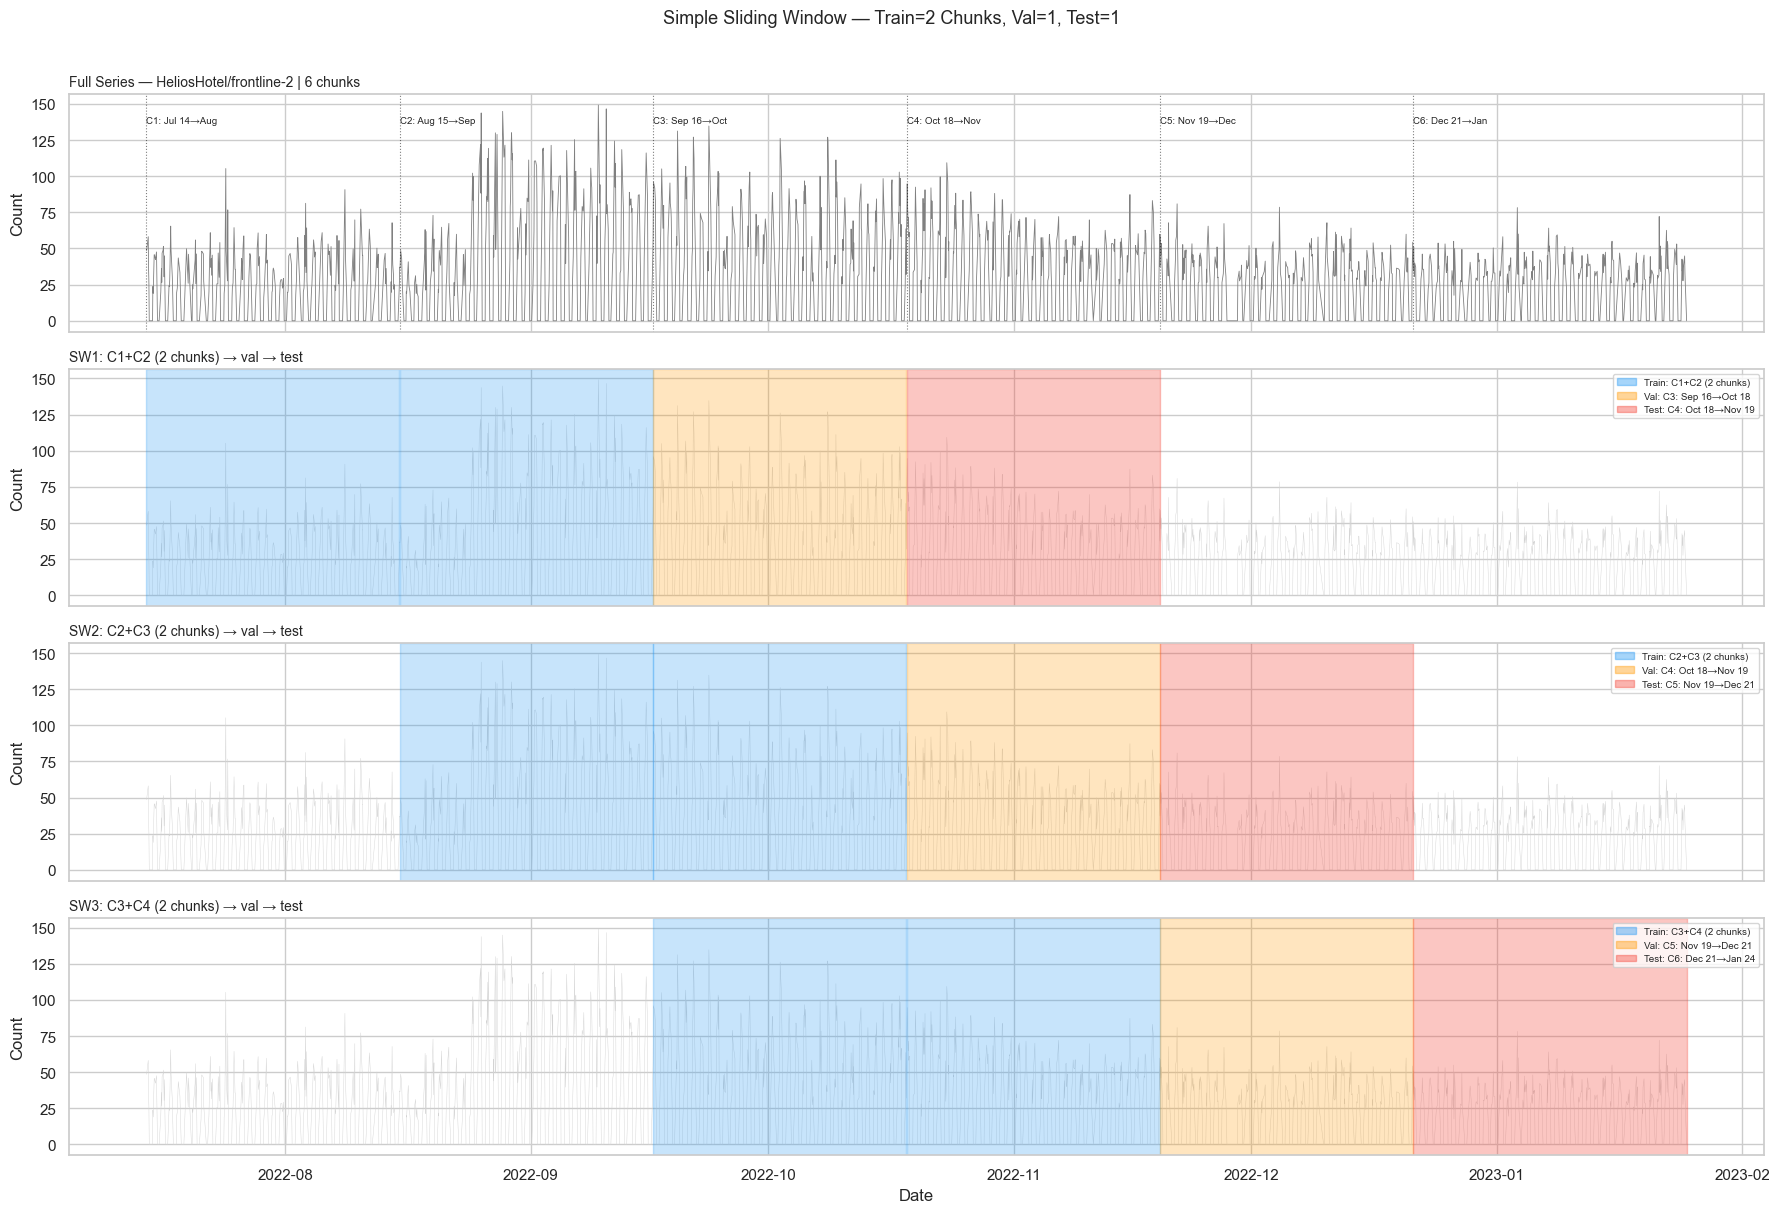

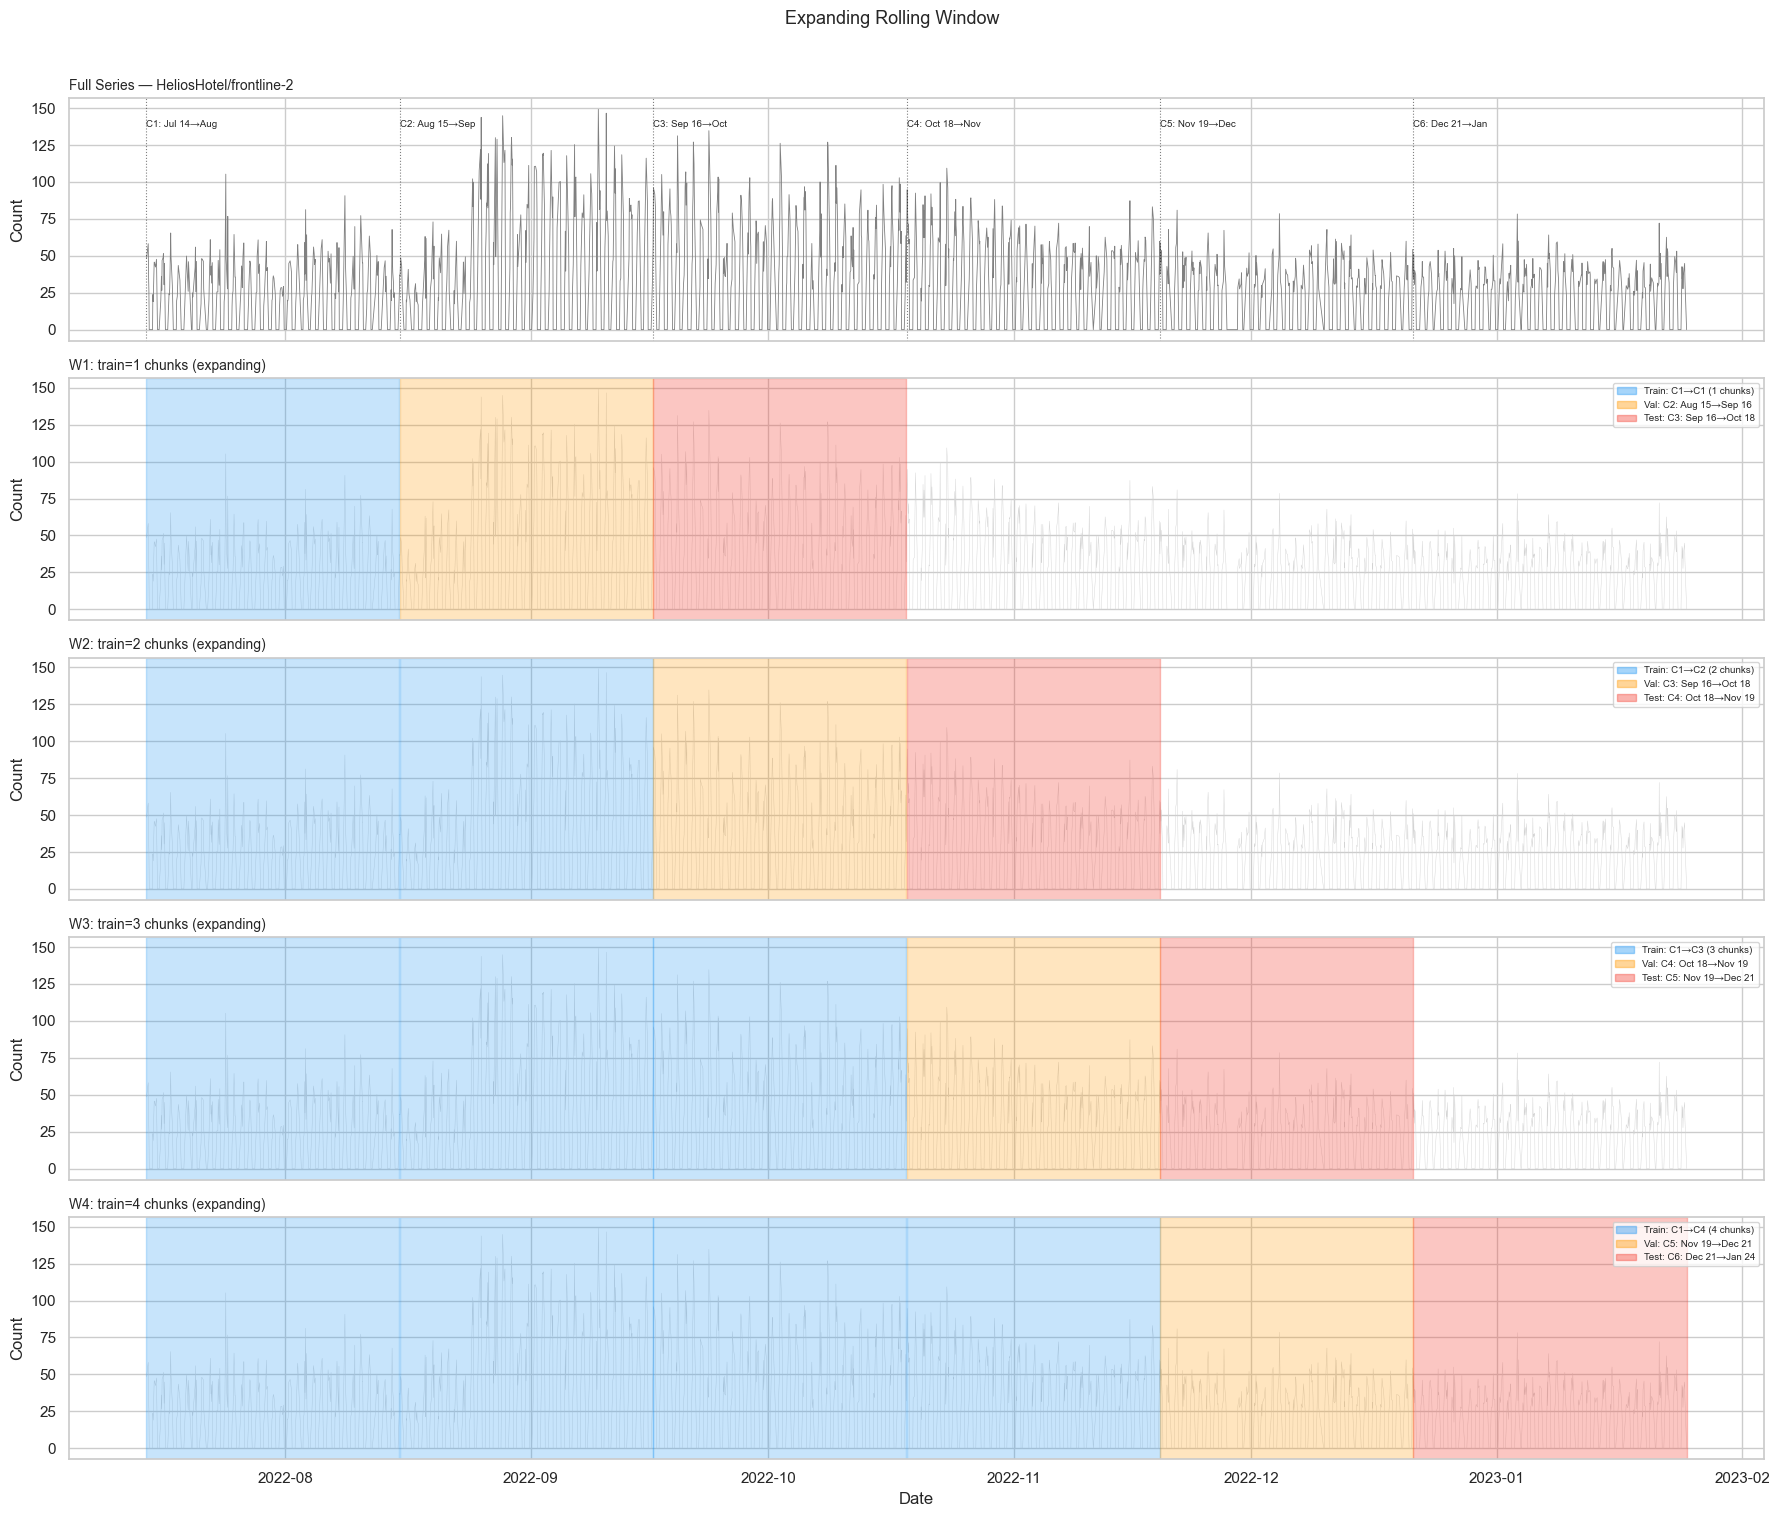

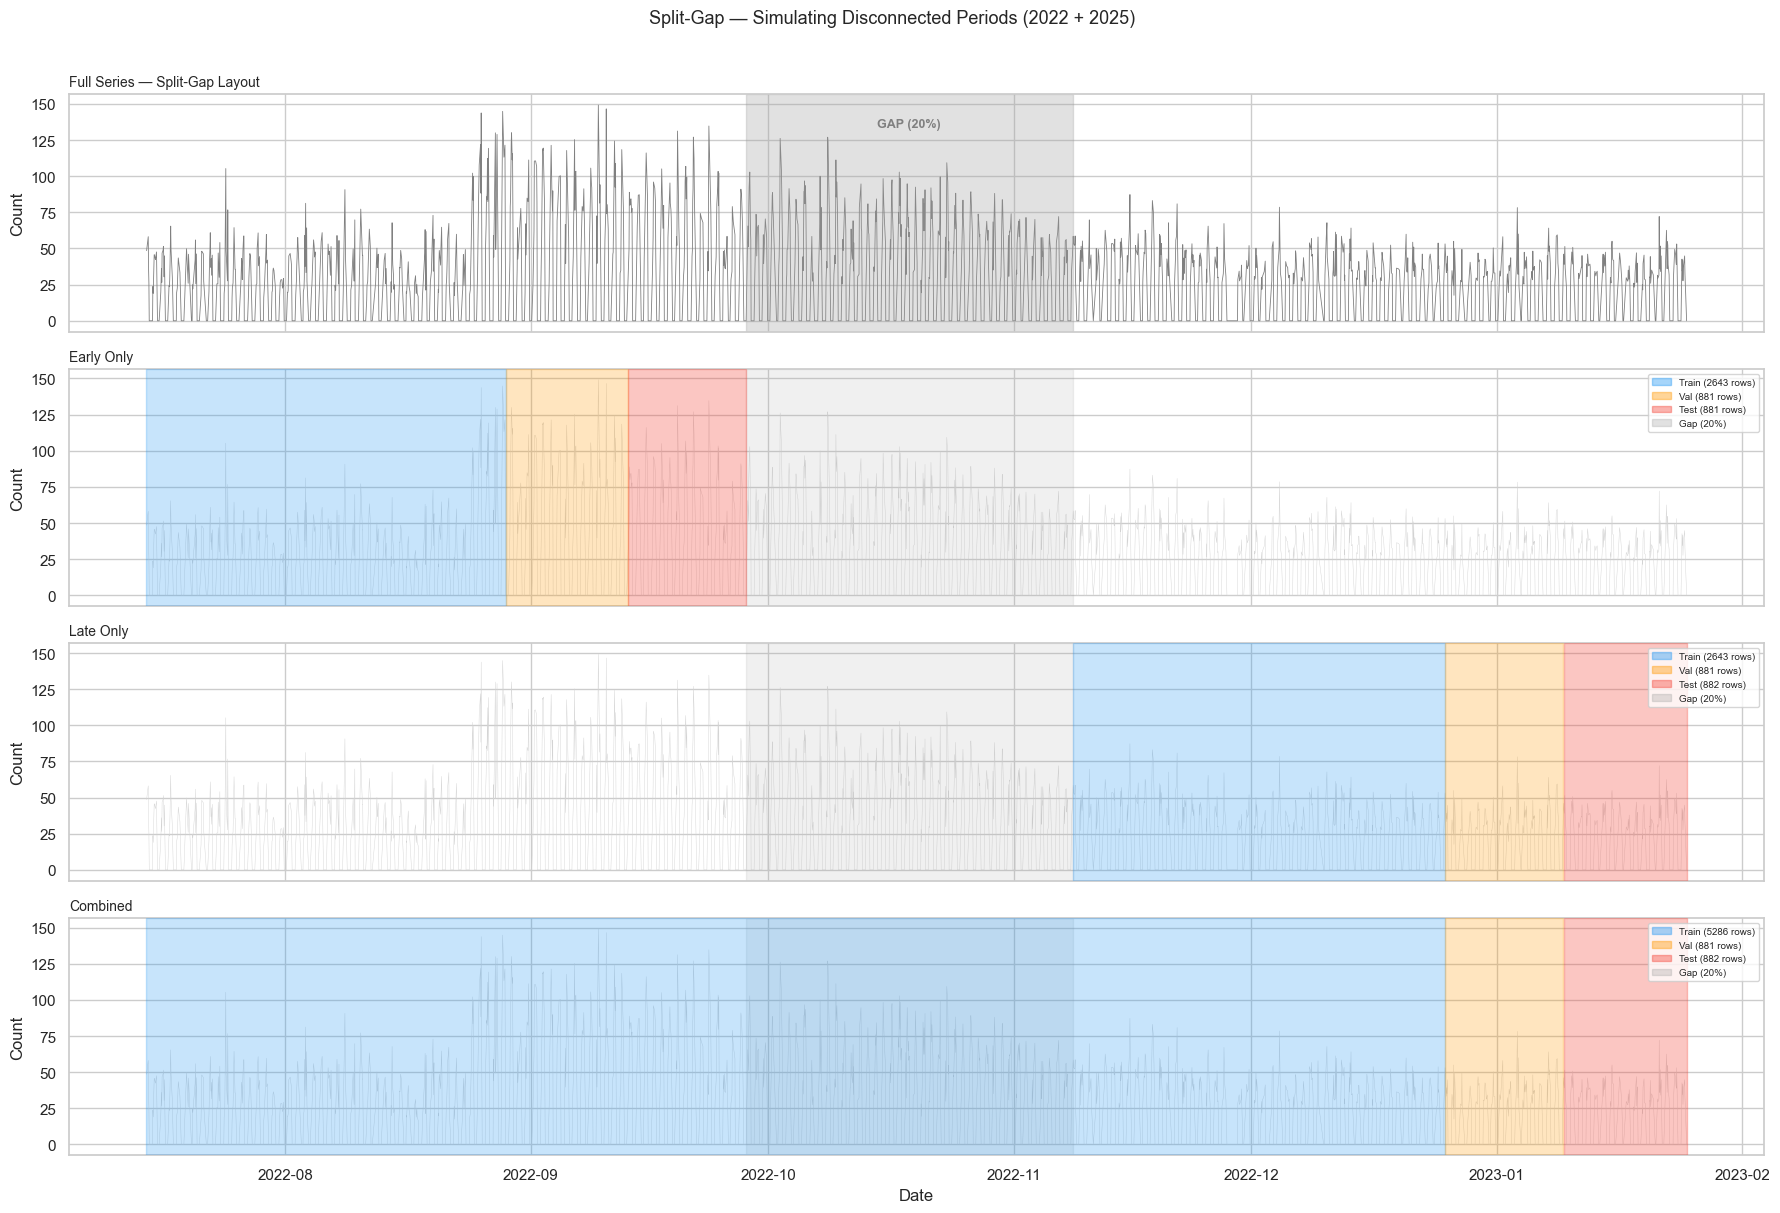

In [11]:
# === 1. SIMPLE SLIDING WINDOW (2 chunks train) ===
chunks = all_chunks['Night0']
simple_windows = simple_windows_all['Night0']
example_uid = df['beach_folder'].value_counts().idxmax()
ds_show = datasets['Night0']
example = ds_show[ds_show['beach_folder'] == example_uid].sort_values('datetime')

c_train = '#2196F3'
c_val = '#FF9800'
c_test = '#F44336'

fig, axes = plt.subplots(len(simple_windows) + 1, 1,
                         figsize=(18, 3 * (len(simple_windows) + 1)), sharex=True)
axes[0].plot(example['datetime'], example['count'], linewidth=0.6, color='gray')
for c in chunks:
    axes[0].axvline(c['start'], color='black', linestyle=':', linewidth=0.8, alpha=0.5)
    axes[0].text(c['start'], example['count'].max() * 0.95, c['label'][:15], fontsize=7, va='top')
axes[0].set_title(f'Full Series \u2014 {example_uid[:40]} | {N_CHUNKS} chunks', fontsize=10, loc='left')
axes[0].set_ylabel('Count')

for w_idx, w in enumerate(simple_windows):
    ax = axes[w_idx + 1]
    ax.plot(example['datetime'], example['count'], linewidth=0.3, color='lightgray', zorder=1)
    for tc in w['train_chunks']:
        ax.axvspan(tc['start'], tc['end'], alpha=0.25, color=c_train, zorder=2)
    val_chunk = chunks[w_idx + 2]
    test_chunk = chunks[w_idx + 3]
    ax.axvspan(val_chunk['start'], val_chunk['end'], alpha=0.25, color=c_val, zorder=2)
    ax.axvspan(test_chunk['start'], test_chunk['end'], alpha=0.3, color=c_test, zorder=2)
    t_patch = mpatches.Patch(color=c_train, alpha=0.4, label=f"Train: {w['train_label']}")
    v_patch = mpatches.Patch(color=c_val, alpha=0.4, label=f"Val: {w['val_label']}")
    te_patch = mpatches.Patch(color=c_test, alpha=0.4, label=f"Test: {w['test_label']}")
    ax.legend(handles=[t_patch, v_patch, te_patch], loc='upper right', fontsize=7)
    ax.set_ylabel('Count')
    ax.set_title(f"{w['name']}: {w['train_label']} \u2192 val \u2192 test", fontsize=10, loc='left')
axes[-1].set_xlabel('Date')
plt.suptitle('Simple Sliding Window \u2014 Train=2 Chunks, Val=1, Test=1', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# === 2. EXPANDING ROLLING WINDOW ===
rw = rolling_windows['Night0']
fig, axes = plt.subplots(len(rw) + 1, 1, figsize=(18, 3 * (len(rw) + 1)), sharex=True)
axes[0].plot(example['datetime'], example['count'], linewidth=0.6, color='gray')
for c in chunks:
    axes[0].axvline(c['start'], color='black', linestyle=':', linewidth=0.8, alpha=0.5)
    axes[0].text(c['start'], example['count'].max() * 0.95, c['label'][:15], fontsize=7, va='top')
axes[0].set_title(f'Full Series \u2014 {example_uid[:40]}', fontsize=10, loc='left')
axes[0].set_ylabel('Count')

for w_idx, w in enumerate(rw):
    ax = axes[w_idx + 1]
    ax.plot(example['datetime'], example['count'], linewidth=0.3, color='lightgray', zorder=1)
    for tc in w['train_chunks']:
        ax.axvspan(tc['start'], tc['end'], alpha=0.25, color=c_train, zorder=2)
    val_chunk = chunks[[i for i, c in enumerate(chunks) if c['label'] == w['val_label']][0]]
    test_chunk = chunks[[i for i, c in enumerate(chunks) if c['label'] == w['test_label']][0]]
    ax.axvspan(val_chunk['start'], val_chunk['end'], alpha=0.25, color=c_val, zorder=2)
    ax.axvspan(test_chunk['start'], test_chunk['end'], alpha=0.3, color=c_test, zorder=2)
    t_patch = mpatches.Patch(color=c_train, alpha=0.4, label=f"Train: {w['train_label']}")
    v_patch = mpatches.Patch(color=c_val, alpha=0.4, label=f"Val: {w['val_label']}")
    te_patch = mpatches.Patch(color=c_test, alpha=0.4, label=f"Test: {w['test_label']}")
    ax.legend(handles=[t_patch, v_patch, te_patch], loc='upper right', fontsize=7)
    ax.set_ylabel('Count')
    ax.set_title(f"{w['name']}: train={len(w['train_chunks'])} chunks (expanding)", fontsize=10, loc='left')
axes[-1].set_xlabel('Date')
plt.suptitle('Expanding Rolling Window', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# === 3. SPLIT-GAP VISUALIZATION ===
sg = split_gap_windows['Night0']
c_gap = '#9E9E9E'
fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)
axes[0].plot(example['datetime'], example['count'], linewidth=0.6, color='gray')
axes[0].axvspan(sg['gap_start'], sg['gap_end'], alpha=0.3, color=c_gap, zorder=2)
axes[0].text(sg['gap_start'] + (sg['gap_end'] - sg['gap_start'])/2, example['count'].max() * 0.9,
            'GAP (20%)', ha='center', fontsize=9, fontweight='bold', color='gray')
axes[0].set_title('Full Series \u2014 Split-Gap Layout', fontsize=10, loc='left')
axes[0].set_ylabel('Count')

for ax_idx, (label, key) in enumerate(zip(['Early Only', 'Late Only', 'Combined'], ['early', 'late', 'combined'])):
    ax = axes[ax_idx + 1]
    ax.plot(example['datetime'], example['count'], linewidth=0.3, color='lightgray', zorder=1)
    ax.axvspan(sg['gap_start'], sg['gap_end'], alpha=0.15, color=c_gap, zorder=2)
    exp = sg[key]
    tr, va, te = exp['train_data'], exp['val_data'], exp['test_data']
    ax.axvspan(tr['datetime'].min(), tr['datetime'].max(), alpha=0.25, color=c_train, zorder=3)
    ax.axvspan(va['datetime'].min(), va['datetime'].max(), alpha=0.25, color=c_val, zorder=3)
    ax.axvspan(te['datetime'].min(), te['datetime'].max(), alpha=0.3, color=c_test, zorder=3)
    t_patch = mpatches.Patch(color=c_train, alpha=0.4, label=f"Train ({len(tr)} rows)")
    v_patch = mpatches.Patch(color=c_val, alpha=0.4, label=f"Val ({len(va)} rows)")
    te_patch = mpatches.Patch(color=c_test, alpha=0.4, label=f"Test ({len(te)} rows)")
    g_patch = mpatches.Patch(color=c_gap, alpha=0.3, label='Gap (20%)')
    ax.legend(handles=[t_patch, v_patch, te_patch, g_patch], loc='upper right', fontsize=7)
    ax.set_ylabel('Count')
    ax.set_title(label, fontsize=10, loc='left')
axes[-1].set_xlabel('Date')
plt.suptitle('Split-Gap \u2014 Simulating Disconnected Periods (2022 + 2025)', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


---
## Prepare Daytime Dataset

Filter to daytime hours, assign sequential `time_idx` per beach.
TFT sees a continuous sequence — no gaps, no night bias.


In [12]:
# Daytime only — no night hours at all
df_day = df[df['is_night'] == 0].copy()
df_day = df_day.sort_values(['beach_folder', 'datetime']).reset_index(drop=True)
df_day['time_idx'] = df_day.groupby('beach_folder').cumcount()
df_day['group_id'] = df_day['beach_folder'].astype(str)

# Keep original datetime for later analysis
df_day['orig_datetime'] = df_day['datetime']

print(f"Daytime dataset: {len(df_day)} rows, {df_day['group_id'].nunique()} beaches")
print(f"Hours per beach: {df_day.groupby('group_id').size().describe()[['min', 'max', 'mean']].to_dict()}")
print(f"Time idx range: 0 to {df_day['time_idx'].max()}")


Daytime dataset: 5922 rows, 5 beaches
Hours per beach: {'min': 944.0, 'max': 1284.0, 'mean': 1184.4}
Time idx range: 0 to 1283


In [13]:
# Parameters for pytorch-forecasting TFT
PF_MAX_ENCODER = 48
PF_MAX_PREDICTION = 24  # predict next 24 daytime hours
PF_BATCH_SIZE = 64
PF_MAX_EPOCHS = 50
PF_HIDDEN_SIZE = 32
PF_LR = 0.03

PF_TIME_VARYING_KNOWN = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_summer']
PF_TIME_VARYING_UNKNOWN = ['count'] + WEATHER_COLS

pf_results = []
pf_cv_details = []


## PyTorch-Forecasting TFT — Experiment Function


In [14]:
def run_pf_experiment(exp_name, exp_type, ds_name, train_df, val_df, test_df,
                      train_label, val_label, test_label):
    common_ids = (set(train_df['group_id'].unique()) &
                  set(val_df['group_id'].unique()) &
                  set(test_df['group_id'].unique()))
    if len(common_ids) == 0:
        print(f"  {exp_name}: no common series, skipping")
        return

    train_df = train_df[train_df['group_id'].isin(common_ids)].copy()
    val_df = val_df[val_df['group_id'].isin(common_ids)].copy()
    test_df = test_df[test_df['group_id'].isin(common_ids)].copy()

    combined = pd.concat([train_df, val_df, test_df]).sort_values(['group_id', 'datetime']).reset_index(drop=True)
    combined['time_idx'] = combined.groupby('group_id').cumcount()

    train_cutoff = combined[combined['datetime'] <= train_df['datetime'].max()]['time_idx'].max()
    val_cutoff = combined[combined['datetime'] <= val_df['datetime'].max()]['time_idx'].max()

    known_reals = [c for c in PF_TIME_VARYING_KNOWN if c in combined.columns]
    unknown_reals = [c for c in PF_TIME_VARYING_UNKNOWN if c in combined.columns]

    print(f"\n  {exp_name} | series={len(common_ids)} | encoder={PF_MAX_ENCODER} | horizon={PF_MAX_PREDICTION}")
    print(f"    Train: {train_label} | Val: {val_label} | Test: {test_label}")

    try:
        training_ds = TimeSeriesDataSet(
            combined[combined['time_idx'] <= val_cutoff],
            time_idx='time_idx',
            target='count',
            group_ids=['group_id'],
            min_encoder_length=PF_MAX_ENCODER // 2,
            max_encoder_length=PF_MAX_ENCODER,
            min_prediction_length=1,
            max_prediction_length=PF_MAX_PREDICTION,
            time_varying_known_reals=['time_idx'] + known_reals,
            time_varying_unknown_reals=unknown_reals,
            target_normalizer=GroupNormalizer(groups=['group_id'], transformation='softplus'),
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

        validation_ds = TimeSeriesDataSet.from_dataset(
            training_ds, combined[combined['time_idx'] <= val_cutoff],
            predict=True, stop_randomization=True
        )
        test_ds = TimeSeriesDataSet.from_dataset(
            training_ds, combined, predict=True, stop_randomization=True
        )

        train_dl = training_ds.to_dataloader(train=True, batch_size=PF_BATCH_SIZE, num_workers=0)
        val_dl = validation_ds.to_dataloader(train=False, batch_size=PF_BATCH_SIZE * 4, num_workers=0)
        test_dl = test_ds.to_dataloader(train=False, batch_size=PF_BATCH_SIZE * 4, num_workers=0)

        t0 = time.time()
        early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, mode='min')

        trainer = pl.Trainer(
            max_epochs=PF_MAX_EPOCHS,
            accelerator='auto',
            devices=DEVICES,
            gradient_clip_val=0.1,
            callbacks=[early_stop],
            enable_model_summary=False,
            enable_progress_bar=True,
        )

        tft = TemporalFusionTransformer.from_dataset(
            training_ds,
            learning_rate=PF_LR,
            hidden_size=PF_HIDDEN_SIZE,
            attention_head_size=2,
            dropout=0.1,
            hidden_continuous_size=PF_HIDDEN_SIZE,
            loss=QuantileLoss(),
            optimizer='adam',
            reduce_on_plateau_patience=4,
        )

        trainer.fit(tft, train_dataloaders=train_dl, val_dataloaders=val_dl)
        elapsed = time.time() - t0

        raw_preds = tft.predict(test_dl, mode="raw", return_x=True,
                                trainer_kwargs=dict(accelerator='cpu'))
        predictions = tft.predict(test_dl, return_y=True, trainer_kwargs=dict(accelerator='cpu'))

        y_pred_raw = predictions.output.cpu().numpy()
        if y_pred_raw.ndim == 3:
            y_pred_raw = y_pred_raw.mean(axis=-1)
        y_pred = np.clip(y_pred_raw.flatten(), 0, None)
        y_true = predictions.y[0].cpu().numpy().flatten()

        m = calc_metrics(y_true, y_pred, y_true.max())

        beach_results = []
        beach_ids = sorted(common_ids)
        n_per = len(y_true) // len(beach_ids) if len(beach_ids) > 0 else len(y_true)
        for i, b in enumerate(beach_ids):
            start = i * n_per
            end = start + n_per
            if end > len(y_true):
                break
            yt = y_true[start:end]
            yp = y_pred[start:end]
            if len(yt) < 3:
                continue
            bm = calc_metrics(yt, yp, yt.max())
            bm['beach'] = b
            bm['max_count'] = yt.max()
            beach_results.append(bm)

        beach_df = pd.DataFrame(beach_results)
        avg_rel = beach_df['RelMAE'].mean() if len(beach_df) > 0 else m['RelMAE']

        pf_results.append({
            'Model': 'PF_TFT', 'Dataset': ds_name, 'Experiment': exp_type,
            'Window': exp_name,
            'MAE': m['MAE'], 'RMSE': m['RMSE'], 'R2': m['R2'],
            'AvgRelMAE_day': avg_rel,
            'Time': elapsed,
            'train_period': train_label, 'val_period': val_label, 'test_period': test_label,
            'train_rows': len(train_df),
        })
        pf_cv_details.append({
            'ds_name': ds_name, 'exp_type': exp_type, 'window': exp_name,
            'model': 'PF_TFT', 'y_true': y_true, 'y_pred': y_pred,
            'beach_df': beach_df,
            'raw_predictions': raw_preds,
            'tft_model': tft,
            'test_dl': test_dl,
        })
        print(f"    {elapsed:.0f}s | MAE={m['MAE']:.1f} | RelMAE={avg_rel:.1f}% | R2={m['R2']:.3f}")

    except Exception as e:
        print(f"    ERROR: {e}")
        import traceback
        traceback.print_exc()


### Build and Run Experiments

Daytime dataset only. Same 3 experiment types.


In [15]:
# Build experiments for daytime dataset
ds_name = 'Daytime'
ds_day = datasets['Daytime']

chunks_day, _ = create_temporal_chunks(ds_day, N_CHUNKS)
all_chunks['Daytime'] = chunks_day

# Simple sliding
sw_day = []
for i in range(len(chunks_day) - 3):
    train_data = pd.concat([chunks_day[i]['data'], chunks_day[i+1]['data']])
    sw_day.append({
        'name': f"SW{i+1}",
        'train_data': train_data,
        'val_data': chunks_day[i+2]['data'],
        'test_data': chunks_day[i+3]['data'],
        'train_label': f"{chunks_day[i]['label'].split(':')[0]}+{chunks_day[i+1]['label'].split(':')[0]}",
        'val_label': chunks_day[i+2]['label'],
        'test_label': chunks_day[i+3]['label'],
    })

# Expanding rolling
ew_day = []
for test_idx in range(2, N_CHUNKS):
    val_idx = test_idx - 1
    train_chunks = chunks_day[:val_idx]
    ew_day.append({
        'name': f"W{len(ew_day)+1}",
        'train_data': pd.concat([c['data'] for c in train_chunks]),
        'val_data': chunks_day[val_idx]['data'],
        'test_data': chunks_day[test_idx]['data'],
        'train_label': f"{train_chunks[0]['label'].split(':')[0]}\u2192{train_chunks[-1]['label'].split(':')[0]} ({len(train_chunks)}ch)",
        'val_label': chunks_day[val_idx]['label'],
        'test_label': chunks_day[test_idx]['label'],
    })

# Split-gap
n = len(ds_day)
ds_day_sorted = ds_day.sort_values('datetime').reset_index(drop=True)
early = ds_day_sorted.iloc[:int(n * 0.4)]
late = ds_day_sorted.iloc[int(n * 0.6):]
gap_start = ds_day_sorted.iloc[int(n * 0.4)]['datetime']
gap_end = ds_day_sorted.iloc[int(n * 0.6)]['datetime']

def split_period_day(period_df, name):
    np_ = len(period_df)
    tr = period_df.iloc[:int(np_ * 0.6)]
    va = period_df.iloc[int(np_ * 0.6):int(np_ * 0.8)]
    te = period_df.iloc[int(np_ * 0.8):]
    return {
        'name': name,
        'train_data': tr, 'val_data': va, 'test_data': te,
        'train_label': f"{name} train ({tr['datetime'].min().strftime('%b %d')}\u2192{tr['datetime'].max().strftime('%b %d')})",
        'val_label': f"{name} val",
        'test_label': f"{name} test",
    }

sg_early = split_period_day(early, "Early")
sg_late = split_period_day(late, "Late")
sg_combined = {
    'name': "Combined",
    'train_data': pd.concat([sg_early['train_data'], sg_late['train_data']]),
    'val_data': sg_late['val_data'],
    'test_data': sg_late['test_data'],
    'train_label': f"Early+Late train",
    'val_label': sg_late['val_label'],
    'test_label': sg_late['test_label'],
}

sg_day = [sg_early, sg_late, sg_combined]

print(f"Daytime experiments:")
print(f"  Simple sliding: {len(sw_day)} windows")
print(f"  Expanding: {len(ew_day)} windows")
print(f"  Split-gap: 3 (Early, Late, Combined)")


Daytime experiments:
  Simple sliding: 3 windows
  Expanding: 4 windows
  Split-gap: 3 (Early, Late, Combined)


In [ ]:
# Prepare daytime df with time_idx for pytorch-forecasting
def prepare_pf_data(data):
    d = data.copy()
    d = d.sort_values(['beach_folder', 'datetime']).reset_index(drop=True)
    d['group_id'] = d['beach_folder'].astype(str)
    return d

# Run simple sliding
print("=" * 70)
print("PYTORCH-FORECASTING TFT \u2014 SIMPLE SLIDING (Daytime)")
print("=" * 70)
for w in sw_day:
    run_pf_experiment(
        exp_name=w['name'], exp_type="Simple", ds_name="Daytime",
        train_df=prepare_pf_data(w['train_data']),
        val_df=prepare_pf_data(w['val_data']),
        test_df=prepare_pf_data(w['test_data']),
        train_label=w['train_label'], val_label=w['val_label'], test_label=w['test_label'],
    )

# Run expanding rolling
print("\n" + "=" * 70)
print("PYTORCH-FORECASTING TFT \u2014 EXPANDING ROLLING (Daytime)")
print("=" * 70)
for w in ew_day:
    run_pf_experiment(
        exp_name=w['name'], exp_type="Expanding", ds_name="Daytime",
        train_df=prepare_pf_data(w['train_data']),
        val_df=prepare_pf_data(w['val_data']),
        test_df=prepare_pf_data(w['test_data']),
        train_label=w['train_label'], val_label=w['val_label'], test_label=w['test_label'],
    )

# Run split-gap
print("\n" + "=" * 70)
print("PYTORCH-FORECASTING TFT \u2014 SPLIT-GAP (Daytime)")
print("=" * 70)
for exp in sg_day:
    run_pf_experiment(
        exp_name=f"SG_{exp['name']}", exp_type="SplitGap", ds_name="Daytime",
        train_df=prepare_pf_data(exp['train_data']),
        val_df=prepare_pf_data(exp['val_data']),
        test_df=prepare_pf_data(exp['test_data']),
        train_label=exp['train_label'], val_label=exp['val_label'], test_label=exp['test_label'],
    )


PYTORCH-FORECASTING TFT — SIMPLE SLIDING (Daytime)

  SW1 | series=5 | encoder=48 | horizon=24
    Train: C1+C2 | Val: C3: Sep 16→Oct 18 | Test: C4: Oct 18→Nov 19


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Output()

### PyTorch-Forecasting Results


In [ ]:
pf_results_df = pd.DataFrame(pf_results)

if len(pf_results_df) > 0:
    print("=" * 70)
    print("PYTORCH-FORECASTING TFT RESULTS (Daytime Only)")
    print("=" * 70)
    cols = ['Model', 'Experiment', 'Window', 'train_rows', 'MAE', 'R2', 'AvgRelMAE_day', 'Time']
    cols = [c for c in cols if c in pf_results_df.columns]
    print(pf_results_df[cols].to_string(index=False))
    pf_results_df.to_csv(save_dir / 'pf_tft_results.csv', index=False)

# Predictions vs Actual for ALL PF experiments
if len(pf_cv_details) > 0:
    for detail_idx, detail in enumerate(pf_cv_details):
        if detail_idx >= len(pf_results_df):
            break
        row = pf_results_df.iloc[detail_idx]

        # 1) Built-in plot_prediction (encoder + decoder + attention)
        if 'raw_predictions' in detail and detail['raw_predictions'] is not None:
            try:
                raw = detail['raw_predictions']
                tft_model = detail['tft_model']
                n_plots = min(4, raw.output['prediction'].shape[0])
                fig, axes = plt.subplots(n_plots, 1, figsize=(16, 3 * n_plots))
                if n_plots == 1:
                    axes = [axes]
                for idx in range(n_plots):
                    tft_model.plot_prediction(raw.x, raw.output, idx=idx, ax=axes[idx],
                                              add_loss_to_title=True)
                plt.suptitle(f"PF_TFT built-in | {row['Experiment']} {row['Window']} | "
                             f"RelMAE={row['AvgRelMAE_day']:.1f}%", fontsize=11, y=1.01)
                plt.tight_layout()
                plt.savefig(save_dir / f"pf_builtin_{row['Experiment']}_{row['Window']}.png", dpi=100)
                plt.show()
            except Exception as e:
                print(f"  plot_prediction failed: {e}")

        # 2) Per-beach actual vs predicted (same style as NF)
        y_true = detail['y_true']
        y_pred = detail['y_pred']
        beach_df = detail.get('beach_df', pd.DataFrame())

        if len(beach_df) > 0:
            top_beaches = beach_df.nlargest(4, 'max_count')
            n_show = len(top_beaches)
            fig, axes = plt.subplots(n_show, 1, figsize=(16, 3 * n_show))
            if n_show == 1:
                axes = [axes]
            beach_ids = sorted(detail.get('beach_df', pd.DataFrame()).get('beach', []))
            n_per = len(y_true) // len(beach_ids) if len(beach_ids) > 0 else len(y_true)

            for ax_i, (_, brow) in enumerate(top_beaches.iterrows()):
                if ax_i >= n_show:
                    break
                b = brow['beach']
                b_idx = beach_ids.index(b) if b in beach_ids else ax_i
                start = b_idx * n_per
                end = start + n_per
                yt = y_true[start:end]
                yp = y_pred[start:end]

                ax = axes[ax_i]
                ax.plot(yt, label='Actual', color='steelblue', linewidth=1)
                ax.plot(yp, label='Predicted', color='coral', linewidth=1, alpha=0.8)
                ax.fill_between(range(len(yt)), yt, yp, alpha=0.1, color='red')
                ax.set_title(f"{b[:30]} | MAE={brow['MAE']:.1f} | R\u00b2={brow['R2']:.3f}", fontsize=9, loc='left')
                ax.legend(loc='upper right', fontsize=7)
                ax.set_ylabel('Count')

            axes[-1].set_xlabel('Daytime Step')
            plt.suptitle(f"PF_TFT | {row['Experiment']} {row['Window']} | "
                         f"RelMAE={row['AvgRelMAE_day']:.1f}%", fontsize=11, y=1.01)
            plt.tight_layout()
            plt.savefig(save_dir / f"pf_pred_{row['Experiment']}_{row['Window']}.png", dpi=100)
            plt.show()
        else:
            fig, ax = plt.subplots(figsize=(16, 4))
            ax.plot(y_true, label='Actual', color='steelblue', linewidth=0.8)
            ax.plot(y_pred, label='Predicted', color='coral', linewidth=0.8, alpha=0.8)
            ax.legend()
            ax.set_title(f"PF_TFT | {row['Experiment']} {row['Window']} | "
                         f"MAE={row['MAE']:.1f} | R\u00b2={row['R2']:.3f}")
            plt.tight_layout()
            plt.savefig(save_dir / f"pf_pred_{row['Experiment']}_{row['Window']}.png", dpi=100)
            plt.show()

    print(f"\nPlotted {len(pf_cv_details)} PF experiment predictions")

    # Error analysis
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    all_true = np.concatenate([d['y_true'] for d in pf_cv_details])
    all_pred = np.concatenate([d['y_pred'] for d in pf_cv_details])

    axes[0].scatter(all_true, all_pred, s=2, alpha=0.3, color='coral')
    mx = max(all_true.max(), all_pred.max())
    axes[0].plot([0, mx], [0, mx], 'r--', linewidth=1)
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')
    axes[0].set_title('PF_TFT: Actual vs Predicted (all experiments)')

    errors = all_true - all_pred
    axes[1].hist(errors, bins=80, color='coral', alpha=0.7, edgecolor='white')
    axes[1].axvline(0, color='red', linestyle='--')
    axes[1].axvline(errors.mean(), color='orange', linestyle='--', label=f'Bias={errors.mean():.1f}')
    axes[1].set_xlabel('Error')
    axes[1].set_title('PF_TFT: Error Distribution')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(save_dir / 'pf_error_analysis.png', dpi=150)
    plt.show()
